# **Parking lot problem**

### Part a. Forecast total number of vehicles entering the parking per day, for next 7 days



# Processing and Visualizing Data

<Axes: xlabel='timestamp'>

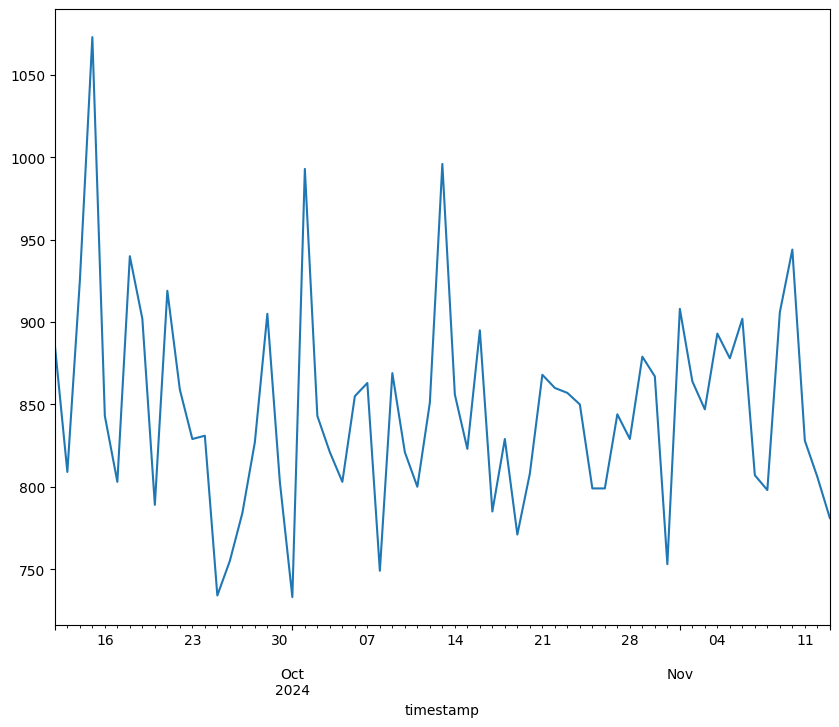

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#loading data
data = pd.read_csv("parkingLot (1).csv")

data['timestamp'] = pd.to_datetime(data['timestamp'])

#spearating entry and exit data
index = data['camera_id'] == 1

data_entry = data[index]
data_entry = data_entry.set_index('timestamp')
data_entry = data_entry.resample('D').size()

data_exit = data[~index]
data_exit = data_exit.set_index('timestamp')
data_exit = data_exit.resample('D').size()
#plottting entry data
fig, ax = plt.subplots()

data_entry.plot(ax= ax, figsize=(10, 8))

In [2]:
print(data_entry)

timestamp
2024-09-12     886
2024-09-13     809
2024-09-14     925
2024-09-15    1073
2024-09-16     843
              ... 
2024-11-09     906
2024-11-10     944
2024-11-11     828
2024-11-12     806
2024-11-13     781
Freq: D, Length: 63, dtype: int64


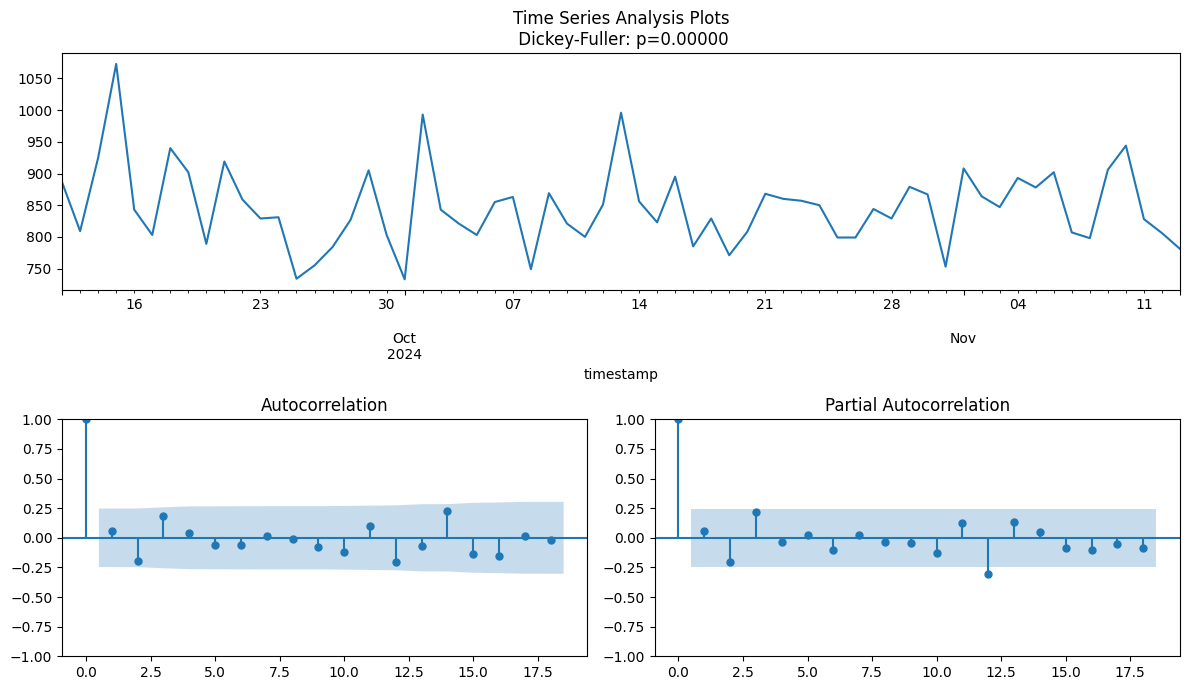

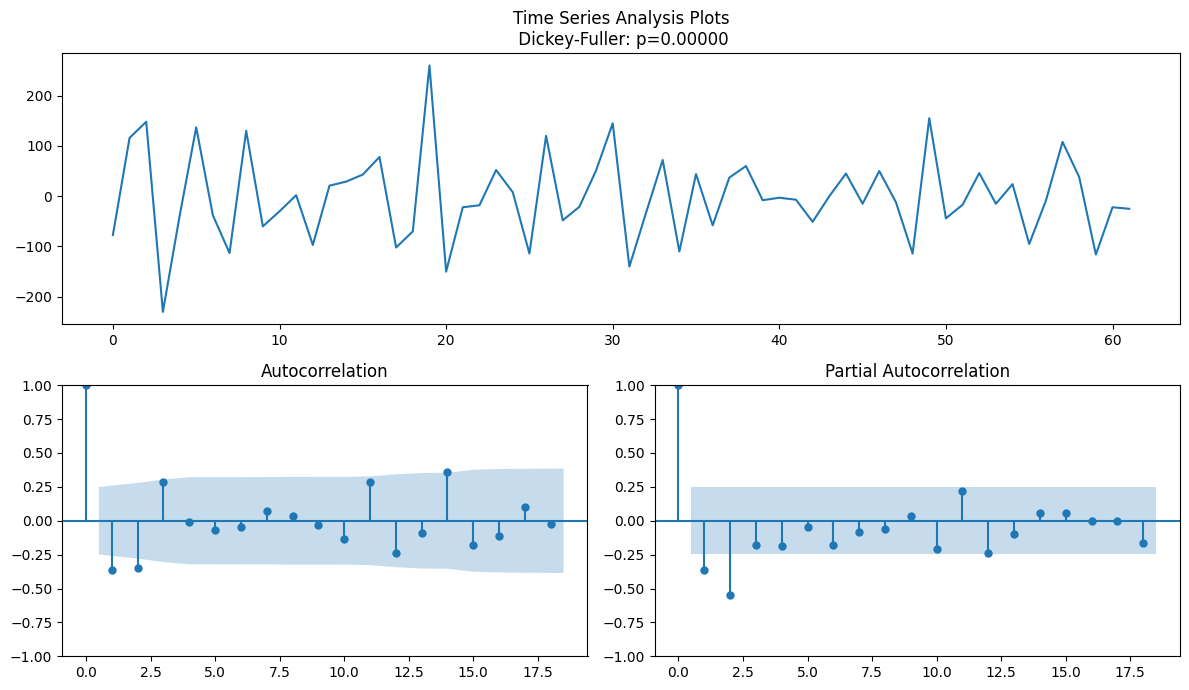

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

tsplot(data_entry)

data_entry_diff_1 = (data_entry[i + 1] - data_entry[i] for i in range(len(data_entry) - 1))
tsplot(data_entry_diff_1)

# Test, Train Split

for (a) part of Q1 we only need to use data_entry

In [4]:
data_train = data_entry[:-7]
data_test = data_entry[-7:]

#  Fitting different model

1. Manual ARIMA Fitting
    - choosing p, d, q manually
2. Auto ARIMA Fittting
3. ETS

### Ignoring warnings

In [5]:
import warnings
warnings.filterwarnings("ignore")

### Manual Fitting

In [6]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data_train, order=(0,0,0), seasonal_order=(3, 0, 1, 7)).fit()
#print(model_fit.summary())

### Auto Fitting

In [7]:
import pmdarima as pm
auto_arima = pm.auto_arima(data_train, stepwise=False, seasonal=True)
auto_arima

ARIMA(order=(0, 0, 3), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

### ETS model

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit an Exponential Smoothing model
model_ETS = ExponentialSmoothing(data_train, seasonal='add', trend='add', seasonal_periods=7).fit()

# Forecasting and Error Calculation


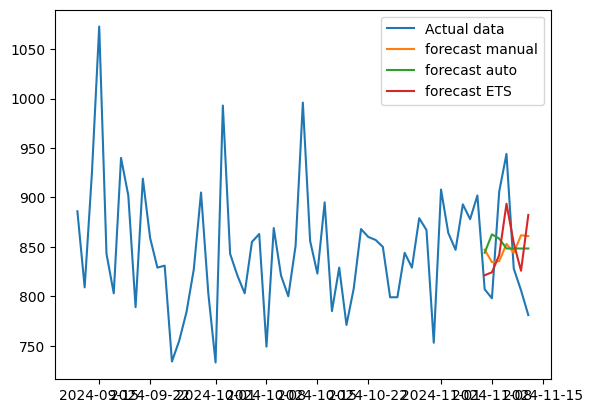

In [16]:
display_data = data_entry.copy()

fig, ax = plt.subplots()
ax.plot(data_entry, label = 'Actual data')

forecast_test = model.forecast(steps = len(data_test))
ax.plot(forecast_test, label='forecast manual')

forecast_test_auto = auto_arima.predict(n_periods=len(data_test))
ax.plot(forecast_test_auto, label='forecast auto')

forecast_test_ETS = model_ETS.forecast(steps=len(data_test))
ax.plot(forecast_test_ETS, label='forecast ETS')

plt.legend()
plt.show()

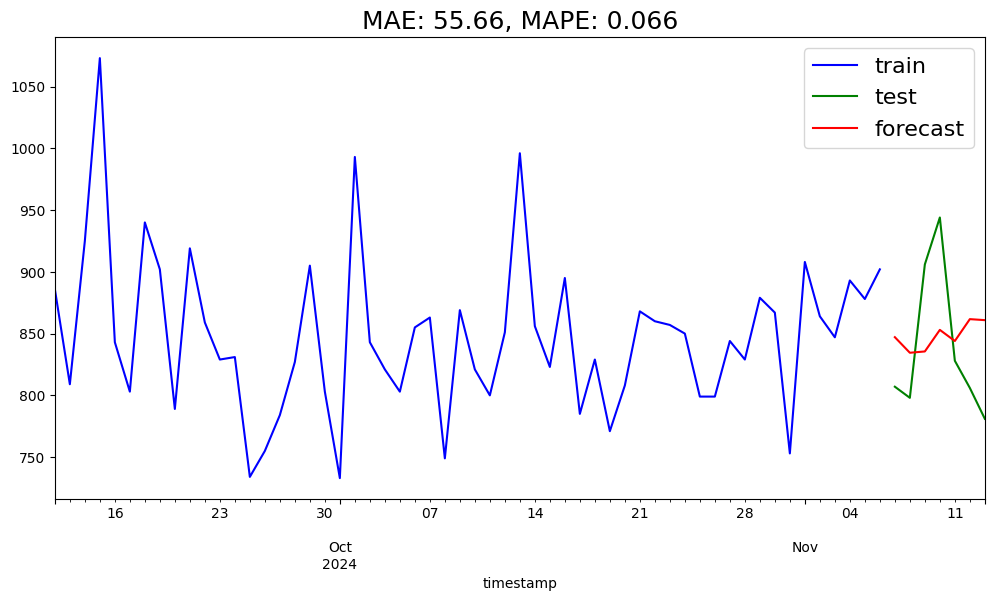

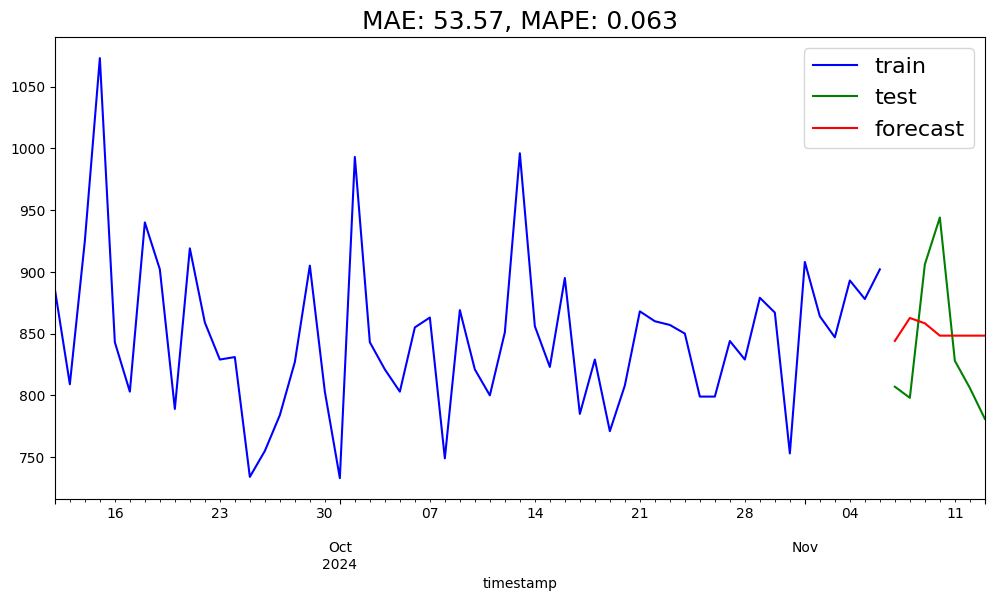

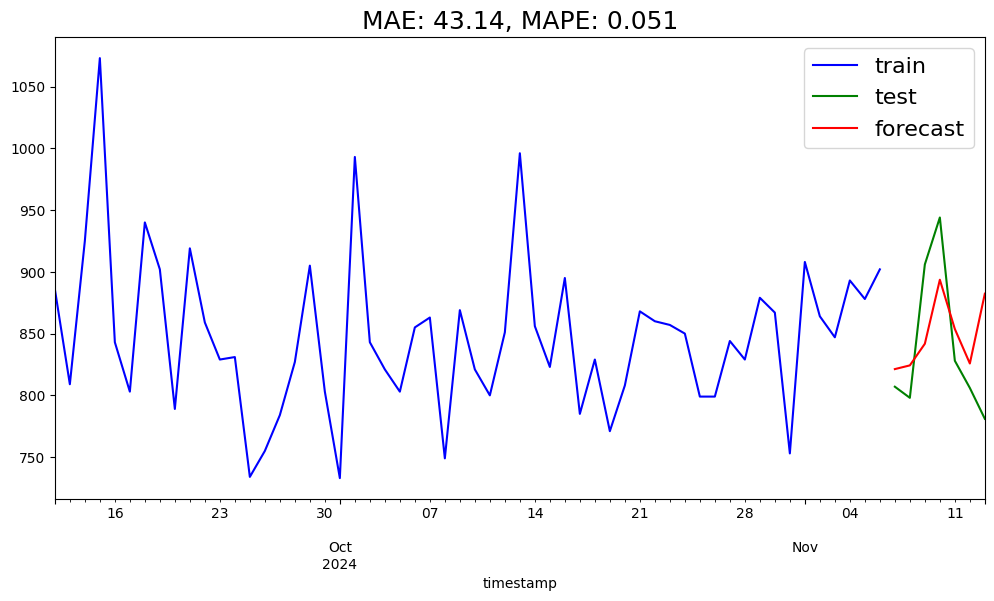

(43.13510959308682, 0.051452295343074404)

In [31]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

plot_forecast(data_train, data_test, forecast_test)
plot_forecast(data_train, data_test, forecast_test_auto)
plot_forecast(data_train, data_test, forecast_test_ETS)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(data_test, forecast_test)
mape = mean_absolute_percentage_error(data_test, forecast_test)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 55.66238734297732
mape - manual: 0.06575790745251114
rmse - manual: 60.85678105344298


In [27]:
mae = mean_absolute_error(data_test, forecast_test_auto)
mape = mean_absolute_percentage_error(data_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 53.573700141878966
mape - auto: 0.06345028898412906
rmse - auto: 58.203647817248786


In [28]:
mae = mean_absolute_error(data_test, forecast_test_ETS)
mape = mean_absolute_percentage_error(data_test, forecast_test_ETS)
rmse = np.sqrt(mean_squared_error(data_test, forecast_test_ETS))

print(f'mae - ETS: {mae}')
print(f'mape - ETS: {mape}')
print(f'rmse - ETS: {rmse}')

mae - ETS: 43.13510959308682
mape - ETS: 0.051452295343074404
rmse - ETS: 51.92476616513588
